In [2]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:5 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]0m
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:9 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [427 kB]
Get:10 https://packages.cloud.google.com/apt google-fast-socket/main amd64 Packages [433 B]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [993 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd6

In [4]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [5]:
seed = 543 # Do not change this
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [28]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')



import time
start = time.time()
     

!pip freeze

In [6]:
print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())
env.reset()
print(env.step(env.action_space.sample()))

Box(-inf, inf, (8,), float32)
Discrete(4)
0
(array([ 0.00793123,  1.4064137 ,  0.4015209 , -0.08623623, -0.00904808,
       -0.08930796,  0.        ,  0.        ], dtype=float32), 0.0878078841506465, False, {})


KeyboardInterrupt: 

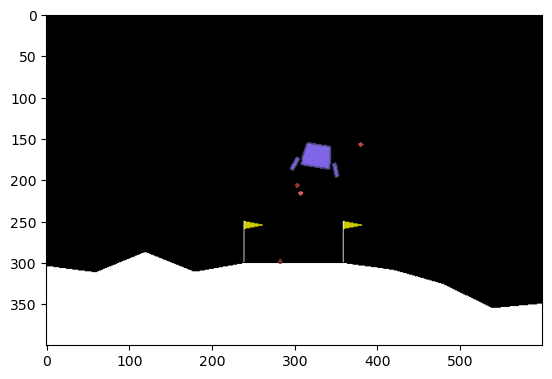

In [7]:

img = plt.imshow(env.render(mode='rgb_array'))
reward_list=[]
env.reset()
done=False
while done==False:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    reward_list.append(reward)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
   

In [13]:
print(sum(reward_list))

-121.48676714061136


In [21]:
class Action_Value_Function(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc=nn.Sequential(
            nn.Linear(8,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,4)
        )

    def forward(self, x):
        return self.fc(x)

In [17]:
a=torch.tensor([1,2,5,4])
print(a[2].item())

5


In [30]:
#state=[1,8]
def select_action(value_func,state,epsilon):
    max_value=float('-inf')
    prob=[epsilon/4]*4
    action=value_func(state).argmax()
    prob[action.detach().item()]+=1-epsilon
    return Categorical(torch.tensor(prob)).sample().item()

def max_value(value_func,state):
    max_value=torch.tensor(float('-inf'))
    return value_func(state).max()

def state_action_value(value_func,state,action):
    return value_func(state)[action]

In [19]:
def play(value_func,epsilon=0.1,gamma=0.99):
    global env
    Q=0.0
    state=env.reset()
    state=torch.tensor(state)
    done=False
    while done==False:
        action=select_action(value_func,state,epsilon)
        state,reward,done,_=env.step(action)
        state=torch.tensor(state)
        Q=gamma*Q+reward
    return Q

In [ ]:
env.close()

XIO:  fatal IO error 22 (Invalid argument) on X server ":0"
      after 312 requests (306 known processed) with 0 events remaining.


In [ ]:
D=[]
#Q=Action_Value_Function()
#Q_h=Action_Value_Function()
optimizer=optim.Adam(Q.parameters(),lr=0.001)
score_list_2=[]

#hyper-prameters
memory_max=400
epsilon=1
eps_decay=0.995
eps_min=0.05
episode=1000
gamma=0.99
C=5
memory_pointer=0

Q.train()
for i in range(episode):
    
    state_t=env.reset()
    
    state_t=torch.tensor(state_t)
    state_t_1=torch.tensor([])
    reward=0.0
    done=False
    Q_est=0.0
    count=0
    while done==False:
        count+=1
        action=select_action(Q,state_t,epsilon)
        state_t_1,reward,done,_=env.step(action)
        state_t_1=torch.tensor(state_t_1)
        if memory_pointer<memory_max:
            D.append((state_t,action,reward,state_t_1,done))
            memory_pointer+=1
        else:
            D.pop(0)
            D.append((state_t,action,reward,state_t_1,done))
        state_t=state_t_1
        s_t,a,r,s_t_1,d=D[random.randint(0,len(D)-1)]
        if d:
            Q_est=torch.tensor([r])
        else:
            Q_est=r+gamma*max_value(Q_h,s_t_1)
        loss=(Q_est-state_action_value(Q,s_t,a))*(Q_est-state_action_value(Q,s_t,a))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if(count==C):
            Q_h.load_state_dict(Q.state_dict())
            count=0
    score=play(Q)
    score_list_2.append(score)
    print("epoch",i,score)
    if(epsilon>eps_min):
        epsilon*=eps_decay

epoch 0 -89.12607576677539
epoch 1 96.96263636164136
epoch 2 -187.79270238241418
epoch 3 99.16813495999142
epoch 4 -72.63600198042181
epoch 5 -142.99944825098473
epoch 6 -284.0290275928685
epoch 7 -98.04963065571914
epoch 8 7.462286390904197
epoch 9 -107.05225289622813
epoch 10 -123.78045846455166
epoch 11 13.98242227741926
epoch 12 -102.80308161630498
epoch 13 -119.00543364633332
epoch 14 -63.3076250048337
epoch 15 -136.54838857993548
epoch 16 -62.50367484939517
epoch 17 -99.29567690345846
epoch 18 -125.92060816705967
epoch 19 -66.0346824269434
epoch 20 -83.20844265125633
epoch 21 -88.7081535171804
epoch 22 -58.89449858202211
epoch 23 -590.6035587156639
epoch 24 -299.5503601741523
epoch 25 -379.1379029542198
epoch 26 -389.445663341201
epoch 27 -163.371822225676
epoch 28 -110.64300316062227
epoch 29 -87.24945677724678
epoch 30 -338.7827174407075
epoch 31 109.91059527427433
epoch 32 -66.94083141529174
epoch 33 -55.61545566474602
epoch 34 -347.5508640632394
epoch 35 -118.24617626502265
e

In [2]:
Q.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    while not done:
        action = select_action(Q,state,0.1)
        actions.append(action)
        state, reward, done, _ = env.step(action)

        total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
    print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) #儲存你測試的結果
    print("length of actions is ", len(actions))

NameError: name 'Q' is not defined

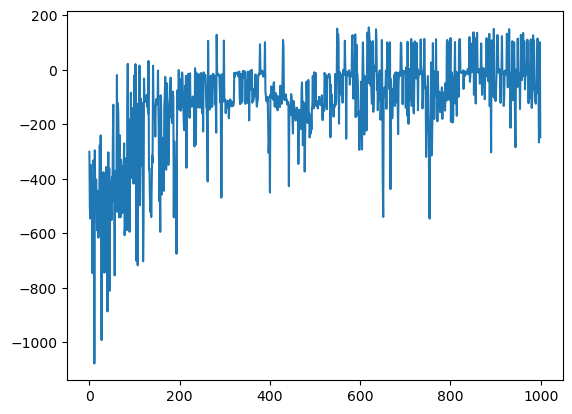

In [32]:
x=range(0,1000)
score_list=score_list+score_list_2
plt.plot(x,score_list)
plt.show()